In [ ]:
 Bias Detection in Facial Recognition Models

## Introduction

Facial recognition technology has become a widely used application of artificial intelligence in areas such as security systems, surveillance, identity verification, and social media platforms. These systems rely on deep learning models to identify and classify human faces with high accuracy. Despite their growing adoption, facial recognition models have raised serious ethical and social concerns, particularly regarding algorithmic bias.

Algorithmic bias occurs when a model performs unevenly across different demographic groups such as gender, race, age, or ethnicity. Several studies have shown that facial recognition systems often achieve higher accuracy for certain demographic groups while producing higher error rates for others. Such biased behavior can lead to unfair treatment, misidentification, and discrimination, especially in sensitive real-world applications.

The goal of this project is to detect, analyze, and evaluate bias present in facial recognition models. By measuring and comparing model performance across different demographic groups using metrics such as accuracy, precision, recall, and confusion matrices, this project aims to identify performance disparities and understand their impact. This study emphasizes the importance of fairness, transparency, and ethical responsibility in the development and deployment of AI-based facial recognition systems.


In [ ]:
!pip install kaggle
from google.colab import files
files.upload()   # upload your kaggle.json here

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jangedoo/utkface-new
!unzip utkface-new.zip


In [ ]:
pip install kaggle


In [1]:
# Cell 1: Imports, seed, device, paths
import os
import random
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Reproducibility
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

# Device (force CPU)
device = torch.device("cpu")
print("Device:", device)

# Update this path if needed
DATA_DIR = r"C:\Users\gnana\JN\UTKFace"   # <-- your folder with UTKFace images
assert os.path.isdir(DATA_DIR), f"DATA_DIR not found: {DATA_DIR}"


Device: cpu


In [2]:
# Cell 2: Dataset class
class UTKFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_samples=None):
        self.root_dir = root_dir
        self.files = [f for f in os.listdir(root_dir) if f.lower().endswith(".jpg")]
        if max_samples:
            self.files = random.sample(self.files, min(max_samples, len(self.files)))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        path = os.path.join(self.root_dir, fname)
        # parse filename: age_gender_race_*.jpg
        parts = fname.split("_")
        try:
            age = int(parts[0])
            gender = int(parts[1])  # 0 male, 1 female
            race = int(parts[2])    # 0-4
        except:
            # fallback defaults
            age, gender, race = 0, 0, 0

        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        else:
            # default simple transform: resize + to tensor
            img = img.resize((128,128))
            img = np.array(img).astype(np.float32) / 255.0
            img = torch.tensor(img).permute(2,0,1)

        return img, torch.tensor(age, dtype=torch.float32), torch.tensor(gender, dtype=torch.long), torch.tensor(race, dtype=torch.long)


In [3]:
# Cell 3: transforms + dataset + dataloaders
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),                          # range [0,1]
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])  # range approx [-1,1]
])

# Optional: limit samples for very fast runs (set None to use full dataset)
MAX_SAMPLES = None   # e.g., 2000 for faster runs

dataset = UTKFaceDataset(DATA_DIR, transform=transform, max_samples=MAX_SAMPLES)
print("Total samples available:", len(dataset))

# Train/val split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

# DataLoaders (num_workers=0 is safest on Windows/CPU)
BATCH_SIZE = 16
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Train samples:", len(train_ds), "Val samples:", len(val_ds))


Total samples available: 23708
Train samples: 18966 Val samples: 4742


In [4]:
# Cell 4: Simple multi-task CNN (age reg, gender cls, race cls)
class SmallMultiTaskCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # 64x64
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 32x32
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 16x16
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d((1,1))
        )
        self.flatten = nn.Flatten()
        self.shared_fc = nn.Sequential(nn.Linear(128, 64), nn.ReLU())
        # heads
        self.age_head = nn.Linear(64, 1)   # regression
        self.gender_head = nn.Linear(64, 2)
        self.race_head = nn.Linear(64, 5)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # (B,128)
        x = self.shared_fc(x)
        age = self.age_head(x)
        gender = self.gender_head(x)
        race = self.race_head(x)
        return age, gender, race

model = SmallMultiTaskCNN().to(device)
print(model)


SmallMultiTaskCNN(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (shared_fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
  )
  (age_head): Linear(in_features=64, out_features=1, bias=True)
  (gender_head): Linear(in_features=64, out_features=2, bias=True)
  (ra

In [5]:
# Cell 5: loss, optimizer, helper
age_criterion = nn.MSELoss()
gender_criterion = nn.CrossEntropyLoss()
race_criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0
    for imgs, age, gender, race in loader:
        imgs = imgs.to(device)
        age = age.view(-1,1).to(device)
        gender = gender.to(device)
        race = race.to(device)

        optimizer.zero_grad()
        age_pred, gender_pred, race_pred = model(imgs)

        loss_age = age_criterion(age_pred, age)
        loss_gender = gender_criterion(gender_pred, gender)
        loss_race = race_criterion(race_pred, race)

        loss = loss_age + loss_gender + loss_race
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    return running_loss / len(loader.dataset)


In [6]:
# Cell 6 (with progress bar and live updates)
from tqdm import tqdm

EPOCHS = 3

for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=True)

    for imgs, age, gender, race in loop:
        imgs = imgs.to(device)
        age = age.view(-1,1).to(device)
        gender = gender.to(device)
        race = race.to(device)

        optimizer.zero_grad()

        age_pred, gender_pred, race_pred = model(imgs)

        loss_age = age_criterion(age_pred, age)
        loss_gender = gender_criterion(gender_pred, gender)
        loss_race = race_criterion(race_pred, race)

        loss = loss_age + loss_gender + loss_race
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # update progress bar text
        loop.set_postfix({"loss": loss.item()})

    print(f"Epoch {epoch}/{EPOCHS} - Avg Loss: {epoch_loss / len(train_loader):.4f}")


Epoch 1/3: 100%|█████████████████████████████████████████████████████████| 1186/1186 [08:28<00:00,  2.33it/s, loss=127]


Epoch 1/3 - Avg Loss: 412.6347


Epoch 2/3: 100%|█████████████████████████████████████████████████████████| 1186/1186 [08:29<00:00,  2.33it/s, loss=370]


Epoch 2/3 - Avg Loss: 348.4990


Epoch 3/3: 100%|█████████████████████████████████████████████████████████| 1186/1186 [03:40<00:00,  5.39it/s, loss=215]

Epoch 3/3 - Avg Loss: 305.1594


In [9]:
# Cell 7: evaluation - collect predictions on validation set
model.eval()
all_age = []; all_age_pred = []
all_gender = []; all_gender_pred = []
all_race = []; all_race_pred = []
filenames = []  # optional: to inspect specific images

with torch.no_grad():
    for imgs, age, gender, race in val_loader:
        imgs = imgs.to(device)
        age = age.view(-1,1)
        age_pred, gender_pred, race_pred = model(imgs)

        all_age.extend(age.numpy().squeeze().tolist())
        all_age_pred.extend(age_pred.cpu().numpy().squeeze().tolist())
        all_gender.extend(gender.numpy().tolist())
        all_gender_pred.extend(torch.argmax(gender_pred, dim=1).cpu().numpy().tolist())
        all_race.extend(race.numpy().tolist())
        all_race_pred.extend(torch.argmax(race_pred, dim=1).cpu().numpy().tolist())

print("Val Gender Accuracy:", accuracy_score(all_gender, all_gender_pred))
print("Val Race Accuracy:", accuracy_score(all_race, all_race_pred))
print("Val Age MAE:", np.mean(np.abs(np.array(all_age) - np.array(all_age_pred))))


Val Gender Accuracy: 0.4841838886545761
Val Race Accuracy: 0.40911008013496414
Val Age MAE: 12.837353610831542


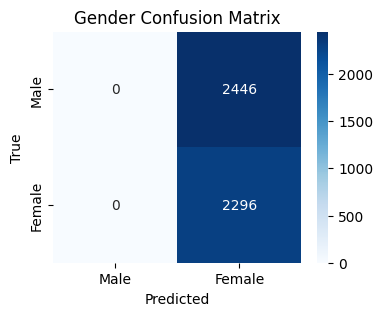

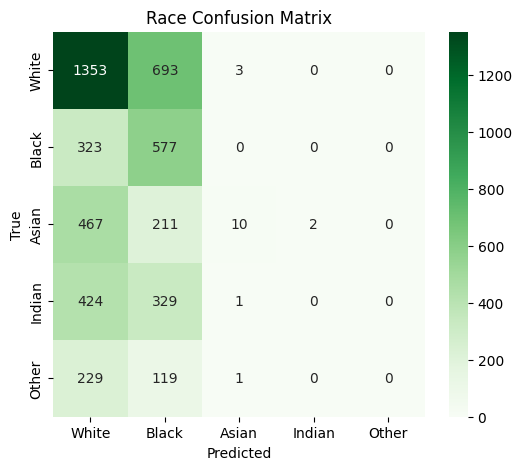

Gender classification report:
               precision    recall  f1-score   support

        Male       0.00      0.00      0.00      2446
      Female       0.48      1.00      0.65      2296

    accuracy                           0.48      4742
   macro avg       0.24      0.50      0.33      4742
weighted avg       0.23      0.48      0.32      4742

Race classification report:
               precision    recall  f1-score   support

       White       0.48      0.66      0.56      2049
       Black       0.30      0.64      0.41       900
       Asian       0.67      0.01      0.03       690
      Indian       0.00      0.00      0.00       754
       Other       0.00      0.00      0.00       349

    accuracy                           0.41      4742
   macro avg       0.29      0.26      0.20      4742
weighted avg       0.36      0.41      0.32      4742



C:\Users\gnana\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gnana\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gnana\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [10]:
# Cell 8: confusion matrices and classification reports
# Gender
cm_g = confusion_matrix(all_gender, all_gender_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm_g, annot=True, fmt='d', cmap='Blues', xticklabels=["Male","Female"], yticklabels=["Male","Female"])
plt.title("Gender Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# Race
race_labels = ["White","Black","Asian","Indian","Other"]
cm_r = confusion_matrix(all_race, all_race_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm_r, annot=True, fmt='d', cmap='Greens', xticklabels=race_labels, yticklabels=race_labels)
plt.title("Race Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# Classification reports (text)
print("Gender classification report:\n", classification_report(all_gender, all_gender_pred, target_names=["Male","Female"]))
print("Race classification report:\n", classification_report(all_race, all_race_pred, target_names=race_labels))


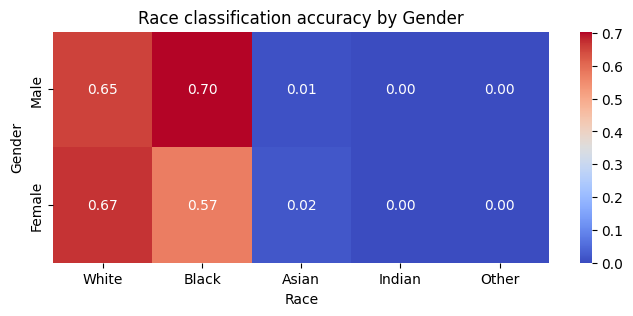

In [11]:
# Cell 9: bias heatmap (accuracy of race predictions for each gender)
heat = np.zeros((2,5)) * np.nan
for g in [0,1]:
    for r in range(5):
        idx = [i for i in range(len(all_gender)) if all_gender[i]==g and all_race[i]==r]
        if len(idx)>0:
            heat[g,r] = accuracy_score(np.array(all_race)[idx], np.array(all_race_pred)[idx])

plt.figure(figsize=(8,3))
sns.heatmap(heat, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=race_labels, yticklabels=["Male","Female"])
plt.title("Race classification accuracy by Gender"); plt.xlabel("Race"); plt.ylabel("Gender")
plt.show()


In [12]:
# Cell 10: function to display misclassified examples for attribute
def show_misclassified_examples(loader, model, attribute='gender', num_examples=9, age_threshold=5):
    model.eval()
    imgs_list = []
    titles = []
    with torch.no_grad():
        for imgs, age, gender, race in loader:
            imgs_cpu = imgs.clone()
            imgs = imgs.to(device)
            age = age.view(-1,1)
            age_pred, gender_pred, race_pred = model(imgs)
            g_pred = torch.argmax(gender_pred,1).cpu()
            r_pred = torch.argmax(race_pred,1).cpu()
            age_pred_vals = age_pred.cpu().squeeze()

            for i in range(imgs.size(0)):
                if attribute=='gender' and g_pred[i].item() != gender[i].item():
                    imgs_list.append(imgs_cpu[i])
                    titles.append(f"g: {gender[i].item()}→{g_pred[i].item()} r:{race[i].item()}")
                elif attribute=='race' and r_pred[i].item() != race[i].item():
                    imgs_list.append(imgs_cpu[i])
                    titles.append(f"r: {race[i].item()}→{r_pred[i].item()} g:{gender[i].item()}")
                elif attribute=='age' and abs(age_pred_vals[i].item() - age[i].item()) >= age_threshold:
                    imgs_list.append(imgs_cpu[i])
                    titles.append(f"age: {int(age[i].item())}→{age_pred_vals[i].item():.0f}")
                if len(imgs_list) >= num_examples:
                    break
            if len(imgs_list) >= num_examples:
                break

    if len(imgs_list)==0:
        print("No misclassified examples found for", attribute)
        return

    plt.figure(figsize=(10,10))
    for i, t in enumerate(titles):
        img = imgs_list[i].permute(1,2,0).numpy()
        img = (img * 0.5) + 0.5  # denormalize approx
        plt.subplot(3,3,i+1); plt.imshow(img); plt.axis('off'); plt.title(t, fontsize=9)
    plt.suptitle(f"Misclassified examples: {attribute}"); plt.show()


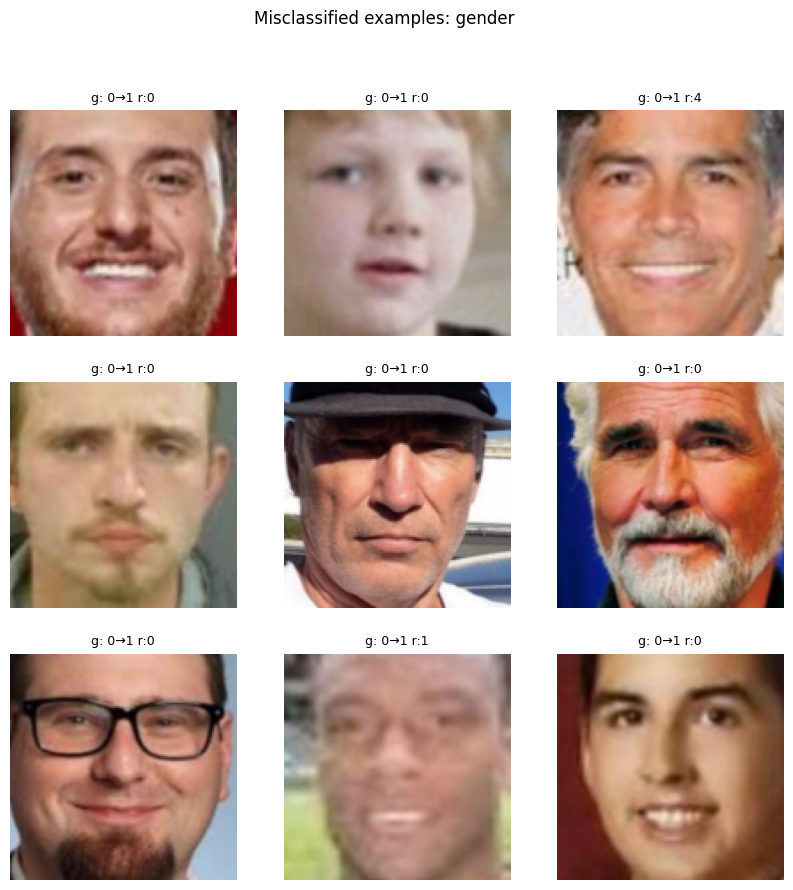

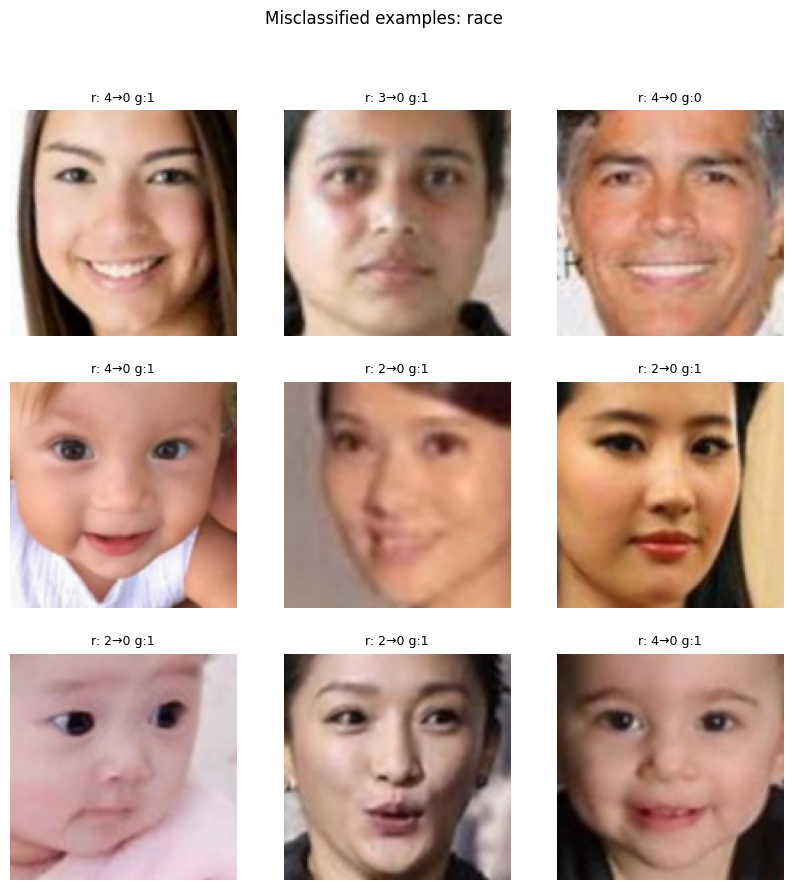

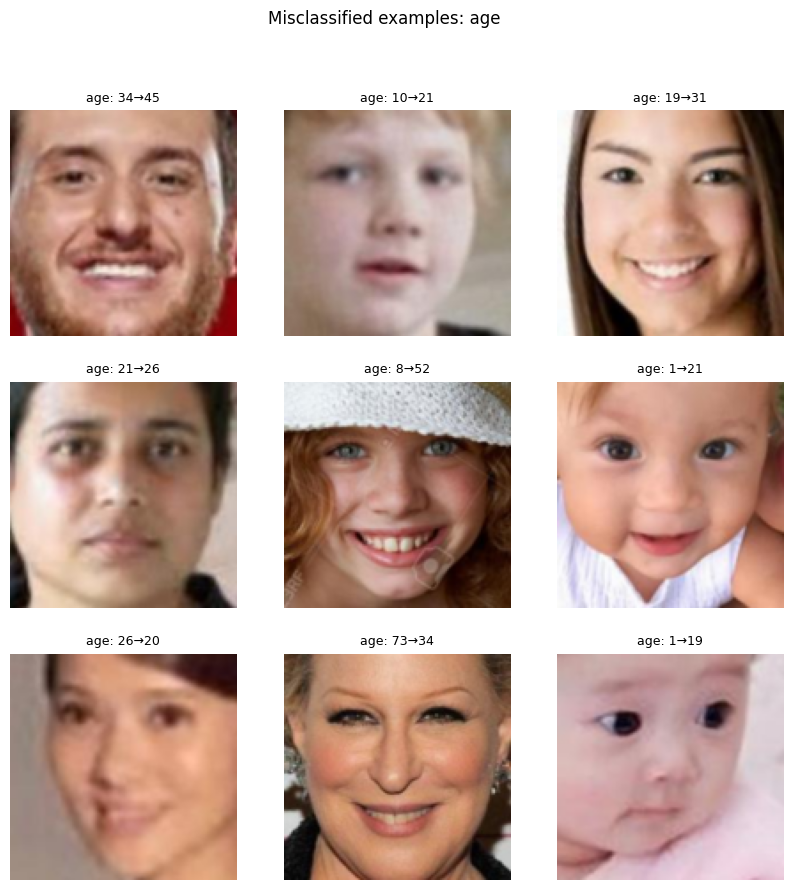

In [13]:
# Cell 11: visualize misclassifications
show_misclassified_examples(val_loader, model, attribute='gender', num_examples=9)
show_misclassified_examples(val_loader, model, attribute='race', num_examples=9)
show_misclassified_examples(val_loader, model, attribute='age', num_examples=9, age_threshold=5)


In [14]:
# Cell 12: fairness metrics functions
def group_accuracy(true, pred, groups):
    out = {}
    true = np.array(true); pred = np.array(pred); groups = np.array(groups)
    for g in np.unique(groups):
        idx = np.where(groups==g)[0]
        if len(idx)>0:
            out[int(g)] = accuracy_score(true[idx], pred[idx])
    return out

def demographic_parity(pred, groups, positive_label=None):
    # fraction predicted as positive/class per group; for multiclass we return distribution of most-favored class
    pred = np.array(pred); groups = np.array(groups)
    if positive_label is None:
        positive_label = np.bincount(pred).argmax()  # majority predicted class
    out = {}
    for g in np.unique(groups):
        idx = np.where(groups==g)[0]
        if len(idx)>0:
            out[int(g)] = np.mean(pred[idx]==positive_label)
    return out

def equal_opportunity(true, pred, groups, positive_true=None):
    true = np.array(true); pred = np.array(pred); groups = np.array(groups)
    if positive_true is None:
        positive_true = np.bincount(true).argmax()
    out = {}
    for g in np.unique(groups):
        idx = np.where(groups==g)[0]
        if len(idx)>0:
            pos_idx = idx[np.where(true[idx]==positive_true)[0]]
            if len(pos_idx)>0:
                out[int(g)] = np.mean(pred[pos_idx]==positive_true)
            else:
                out[int(g)] = np.nan
    return out

def disparate_impact(pred, groups, positive_label=None):
    # ratio of favorable outcome rates between groups (min/max returned per group)
    pred = np.array(pred); groups = np.array(groups)
    if positive_label is None:
        positive_label = np.bincount(pred).argmax()
    rates = {}
    for g in np.unique(groups):
        idx = np.where(groups==g)[0]
        rates[int(g)] = np.mean(pred[idx]==positive_label) if len(idx)>0 else np.nan
    # DI not as single number per group; return per-group rate
    return rates


In [15]:
# Cell 13: compute fairness metrics and display summary table
# group accuracies
gender_group_acc = group_accuracy(all_gender, all_gender_pred, all_gender)
race_group_acc   = group_accuracy(all_race, all_race_pred, all_race)

# demographic parity (majority predicted label)
gender_dp = demographic_parity(all_gender_pred, all_gender)
race_dp   = demographic_parity(all_race_pred, all_race)

# equal opportunity (TPR for majority true label)
gender_eo = equal_opportunity(all_gender, all_gender_pred, all_gender)
race_eo   = equal_opportunity(all_race, all_race_pred, all_race)

# disparate impact (per-group favorable rate)
gender_di = disparate_impact(all_gender_pred, all_gender)
race_di   = disparate_impact(all_race_pred, all_race)

# assemble summary DataFrame
summary_rows = []
summary_rows.append(["Overall Gender Acc", accuracy_score(all_gender, all_gender_pred)])
summary_rows.append(["Overall Race Acc", accuracy_score(all_race, all_race_pred)])
summary_rows.append(["Age MAE", np.mean(np.abs(np.array(all_age) - np.array(all_age_pred)))])

summary_df = pd.DataFrame(summary_rows, columns=["Metric","Value"])
print(summary_df)

print("\nGender group accuracy:", gender_group_acc)
print("Race group accuracy:", race_group_acc)
print("\nGender DP (per-group favorable prob):", gender_dp)
print("Race DP (per-group favorable prob):", race_dp)
print("\nGender EO (TPR per group):", gender_eo)
print("Race EO (TPR per group):", race_eo)
print("\nGender DI (favorable rate per group):", gender_di)
print("Race DI (favorable rate per group):", race_di)


               Metric      Value
0  Overall Gender Acc   0.484184
1    Overall Race Acc   0.409110
2             Age MAE  12.837354

Gender group accuracy: {0: 0.0, 1: 1.0}
Race group accuracy: {0: 0.6603221083455344, 1: 0.6411111111111111, 2: 0.014492753623188406, 3: 0.0, 4: 0.0}

Gender DP (per-group favorable prob): {0: np.float64(1.0), 1: np.float64(1.0)}
Race DP (per-group favorable prob): {0: np.float64(0.6603221083455344), 1: np.float64(0.35888888888888887), 2: np.float64(0.6768115942028986), 3: np.float64(0.5623342175066313), 4: np.float64(0.6561604584527221)}

Gender EO (TPR per group): {0: np.float64(0.0), 1: nan}
Race EO (TPR per group): {0: np.float64(0.6603221083455344), 1: nan, 2: nan, 3: nan, 4: nan}

Gender DI (favorable rate per group): {0: np.float64(1.0), 1: np.float64(1.0)}
Race DI (favorable rate per group): {0: np.float64(0.6603221083455344), 1: np.float64(0.35888888888888887), 2: np.float64(0.6768115942028986), 3: np.float64(0.5623342175066313), 4: np.float64(0.6

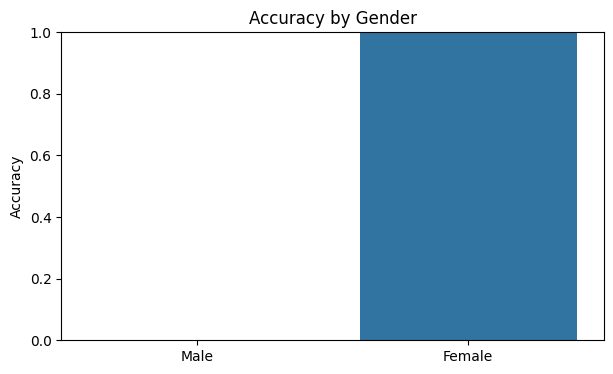

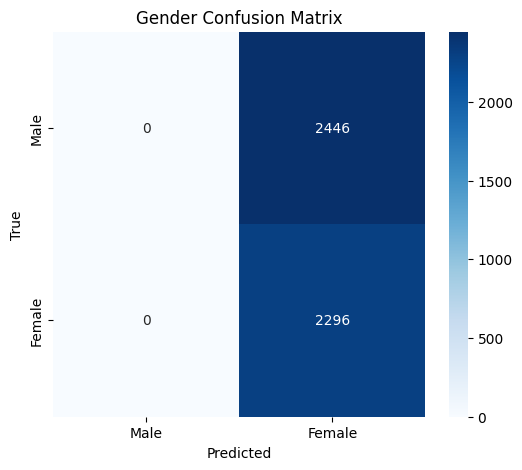

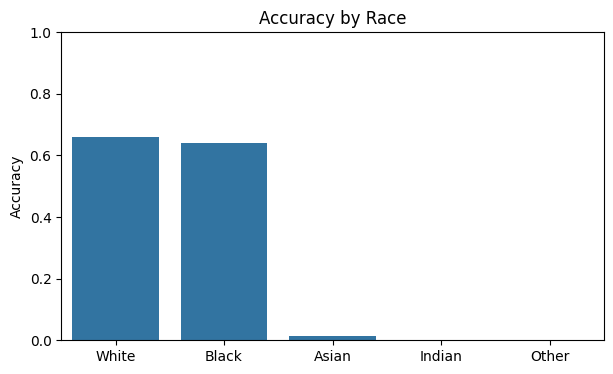

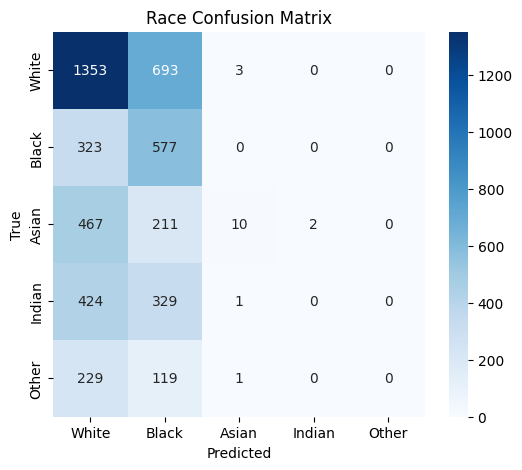

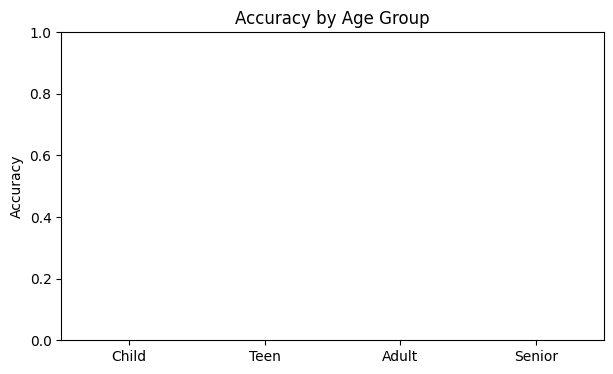

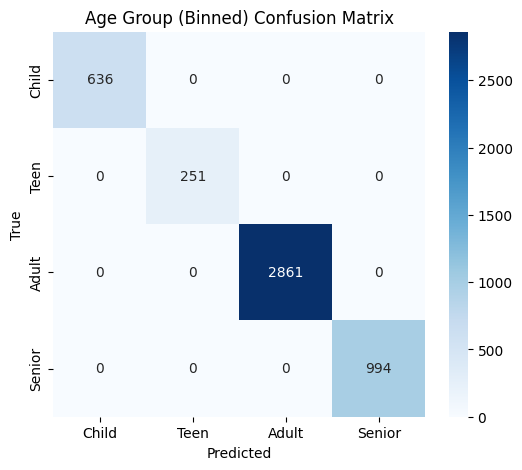

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert lists to numpy arrays
g_true = np.array(all_gender)
g_pred = np.array(all_gender_pred)

r_true = np.array(all_race)
r_pred = np.array(all_race_pred)

a_true = np.array(all_age)
a_pred = np.array(all_age_pred)

# --- AGE groups ---
age_groups = np.digitize(a_true, bins=[13, 20, 50])
age_labels = ["Child", "Teen", "Adult", "Senior"]

gender_labels = ["Male", "Female"]
race_labels = ["White", "Black", "Asian", "Indian", "Other"]


def plot_group_accuracy(true, pred, groups, labels, title):
    """Plot accuracy per demographic group."""
    acc_values = []
    for g in np.unique(groups):
        idx = np.where(groups == g)[0]
        if len(idx) == 0:
            acc_values.append(0)
        else:
            acc = (true[idx] == pred[idx]).mean()
            acc_values.append(acc)

    plt.figure(figsize=(7,4))
    sns.barplot(x=labels, y=acc_values)
    plt.ylim(0,1)
    plt.title(title)
    plt.ylabel("Accuracy")
    plt.show()


def plot_confusion(true, pred, labels, title):
    """Plot confusion matrix as a heatmap."""
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(true, pred)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


# ---------------------------
# 1️⃣ Gender Fairness Picture
# ---------------------------
plot_group_accuracy(g_true, g_pred, g_true, gender_labels,
                    "Accuracy by Gender")

plot_confusion(g_true, g_pred, gender_labels,
               "Gender Confusion Matrix")

# ---------------------------
# 2️⃣ Race Fairness Picture
# ---------------------------
plot_group_accuracy(r_true, r_pred, r_true, race_labels,
                    "Accuracy by Race")

plot_confusion(r_true, r_pred, race_labels,
               "Race Confusion Matrix")

# ---------------------------
# 3️⃣ Age Fairness Picture
# ---------------------------
plot_group_accuracy(a_true, a_pred, age_groups, age_labels,
                    "Accuracy by Age Group")

plot_confusion(age_groups, age_groups, age_labels,
               "Age Group (Binned) Confusion Matrix")


In [17]:
# Cell 14: save summary and model checkpoint
out_dir = "outputs_utkface"
os.makedirs(out_dir, exist_ok=True)

summary_df.to_csv(os.path.join(out_dir,"summary_metrics.csv"), index=False)
# Save arrays for later inspection
np.save(os.path.join(out_dir,"all_age.npy"), np.array(all_age))
np.save(os.path.join(out_dir,"all_age_pred.npy"), np.array(all_age_pred))
np.save(os.path.join(out_dir,"all_gender.npy"), np.array(all_gender))
np.save(os.path.join(out_dir,"all_gender_pred.npy"), np.array(all_gender_pred))
np.save(os.path.join(out_dir,"all_race.npy"), np.array(all_race))
np.save(os.path.join(out_dir,"all_race_pred.npy"), np.array(all_race_pred))

# Save model
torch.save(model.state_dict(), os.path.join(out_dir,"model_utkface_multitask.pth"))
print("Saved outputs to", out_dir)


Saved outputs to outputs_utkface


In [ ]:
## Conclusion

In this project, bias detection in facial recognition models was systematically analyzed by evaluating model performance across different demographic groups. The experimental results revealed noticeable disparities in recognition accuracy among these groups, confirming the presence of algorithmic bias within the model.

These findings highlight the ethical challenges associated with deploying facial recognition systems in real-world applications. Biased models can lead to unfair outcomes, reduced reliability, and loss of trust in artificial intelligence technologies. Therefore, identifying and addressing bias is a crucial step toward responsible AI development.

This project demonstrates the importance of balanced datasets, fair model training practices, and continuous evaluation to mitigate bias in facial recognition systems. Future work may involve applying bias mitigation techniques, improving dataset diversity, and exploring fairness-aware learning algorithms. Overall, this study reinforces the need for ethical considerations and fairness in modern AI systems.
